## Defining important Functions and importing libraries

In [1]:
import yaml
import pandas as pd
import os
os.chdir('../')
import logging

from src.database.manager import DatabaseManager
from src.preprocessing.database_preprocessing import DatabasePreprocessor
from src.utils.schema_reader import SchemaReader
import sys

import matplotlib.pyplot as plt
import seaborn as sns


# Configure logging
logging.basicConfig(level=logging.INFO)


def read_params_file(file_path):
    """
    Reads a YAML parameters file and returns the content as a dictionary.

    Args:
        file_path (str): The path to the YAML parameters file.

    Returns:
        dict: A dictionary containing the parameters read from the file.
    """
    with open(file_path) as yaml_file:
        params = yaml.safe_load(yaml_file)
    return params


def connect_to_database(params):
    """
    Connects to the database using the provided parameters.

    Args:
        params (dict): Database connection parameters.

    Returns:
        DatabaseManager: An instance of DatabaseManager representing the database connection.
    """
    db_manager = DatabaseManager(dbname=params['database']['config']['dbname'],
                                 host=params['database']['config']['host'],
                                 user=params['database']['config']['user'],
                                 port=params['database']['config']['port'],
                                 password=params['database']['config']['password'])

    return db_manager



## Connecting to the database 

In [2]:

params = read_params_file(os.path.join('config', 'params.yaml'))

# Connect to the database
db_manager = connect_to_database(params)

# Process training dataset
########################################################################
train_table_name = params['database']['train_table_name']

## Reading the Training table

In [3]:
df = db_manager.select_from_table(table_name=train_table_name ,
                             schema_file_path=params['schemas']['training_schema_path'])

In [4]:
df.head()

,"""age""","""job""","""marital""","""education""","""default""","""housing""","""loan""","""contact""","""month""","""day_of_week""","""duration""","""campaign""","""pdays""","""previous""","""poutcome""","""y"""
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


## Checking for nulls and datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   "age"          32950 non-null  int64 
 1   "job"          32950 non-null  object
 2   "marital"      32950 non-null  object
 3   "education"    32950 non-null  object
 4   "default"      32950 non-null  object
 5   "housing"      32950 non-null  object
 6   "loan"         32950 non-null  object
 7   "contact"      32950 non-null  object
 8   "month"        32950 non-null  object
 9   "day_of_week"  32950 non-null  object
 10  "duration"     32950 non-null  int64 
 11  "campaign"     32950 non-null  int64 
 12  "pdays"        32950 non-null  int64 
 13  "previous"     32950 non-null  int64 
 14  "poutcome"     32950 non-null  object
 15  "y"            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


- No nulls in the data
- Datatypes seems correct

## Checking target variable 

In [6]:
df['"y"'].value_counts()/len(df)

"y"
no     0.887344
yes    0.112656
Name: count, dtype: float64

Data is highly imbalanced 

## Checking Independent variables

### Checking bank client data

#### "Age"

<Axes: >

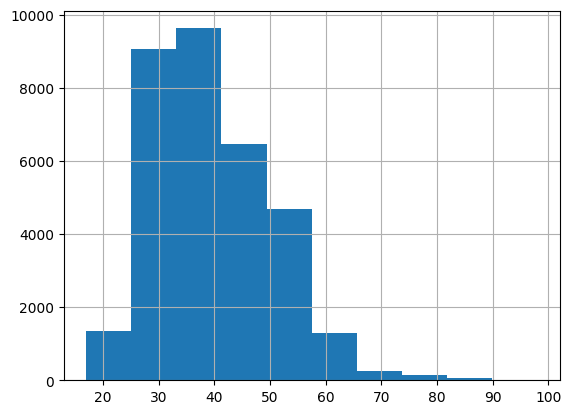

In [7]:
df['"age"'].hist()

- Normally distributed and the average nearly 40 
- We might use binning here as different age groups might have tendencies to use Term deposits

#### "education"

In [8]:
df['"education"'].unique()

array(['basic.9y', 'university.degree', 'basic.4y', 'high.school',
       'professional.course', 'unknown', 'basic.6y', 'illiterate'],
      dtype=object)

- We have the following categories ['basic.9y', 'university.degree', 'basic.4y', 'high.school',
       'professional.course', 'unknown', 'basic.6y', 'illiterate']
- We might categorize these jobs into highly educated or not as highly educated customers might tend to use Term deposits

In [9]:
df['"marital"'].value_counts()

"marital"
married     19953
single       9257
divorced     3675
unknown        65
Name: count, dtype: int64

- We have the following categories : ['married', 'divorced', 'single', 'unknown']
- This feature might be important as single customers might have enough balance to use in Term deposits

#### "job"

In [10]:
df['"job"'].value_counts()

"job"
admin.           8314
blue-collar      7441
technician       5400
services         3196
management       2345
retired          1366
entrepreneur     1160
self-employed    1099
housemaid         855
unemployed        798
student           711
unknown           265
Name: count, dtype: int64

- we have these jobs :  ['blue-collar', 'entrepreneur', 'retired', 'admin.', 'student',
            'services', 'technician', 'self-employed', 'management',
            'unemployed', 'unknown', 'housemaid'] 

- We might check if some particular jobs have more tendencies to accept Term deposits 

#### "default"

In [11]:
df['"default"'].value_counts()

"default"
no         26007
unknown     6940
yes            3
Name: count, dtype: int64

- We have the following categories : ['unknown', 'no', 'yes']
- unknown simply means that this will be missing ,
 so we have 26000 --> no , 
            3 --> yes, 
            7000 --> missing , 
this feature might not be useful , but we will check its relationship with the target variable

#### "housing" indicates if the customer had a housing loan or not

In [12]:
df['"housing"'].value_counts()

"housing"
yes        17254
no         14900
unknown      796
Name: count, dtype: int64

- we have the following categories : ['no', 'yes', 'unknown']
- unknown simply means that this will be missing , we will need a way to fill these missing values

#### "loan" indicates if the customer had a personal loan or not

In [13]:
df['"loan"'].value_counts()

"loan"
no         27131
yes         5023
unknown      796
Name: count, dtype: int64

- we have the following categories : ['no', 'yes', 'unknown']
- unknown simply means that this will be missing , we will need a way to fill these missing values

### Checking Current campaign statistics

##### '"duration"' represents the last time the customer was campaigned in seconds

<Axes: >

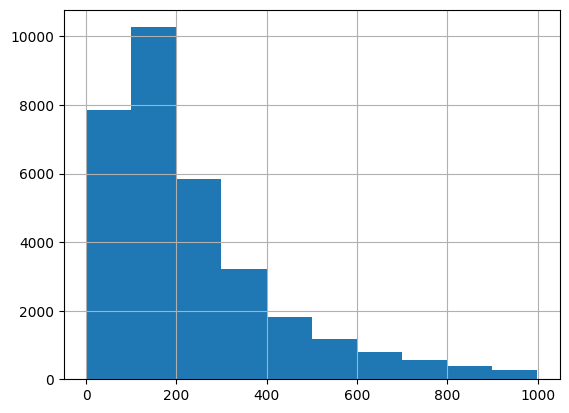

In [14]:
df['"duration"'].loc[df['"duration"']  < 1000].hist()

Right skewed --> most of of the customers were contacted recently

#### '"day_of_week"' represents the last contact day of the month

In [15]:
df['"day_of_week"'].value_counts()

"day_of_week"
thu    6857
mon    6812
wed    6515
tue    6444
fri    6322
Name: count, dtype: int64

- We have the following categories : ['wed', 'mon', 'tue', 'fri', 'thu']

#### '"month"' represents the last contact day of the month

In [16]:
df['"month"'].unique()

array(['nov', 'jul', 'may', 'jun', 'aug', 'mar', 'oct', 'apr', 'sep',
       'dec'], dtype=object)

- We have the following categories : ['nov', 'jul', 'may', 'jun', 'aug', 'mar', 'oct', 'apr', 'sep',
       'dec']

#### Represents the last contact communication type 

In [17]:
df['"contact"'].unique()

array(['cellular', 'telephone'], dtype=object)

- We have the following categories : ['cellular', 'telephone']

#### "campaign" represents the number of contacts performed during this campaign

<Axes: >

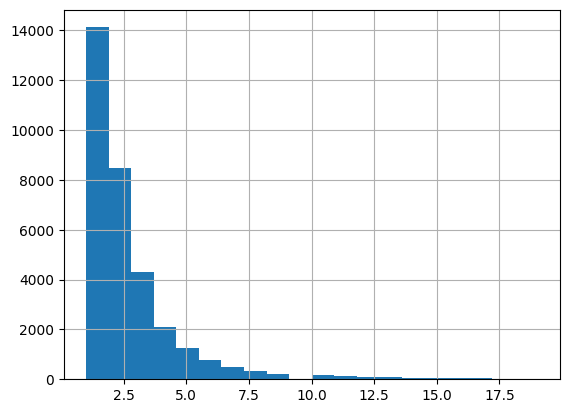

In [18]:
df['"campaign"'].loc[df['"campaign"']  < 20].hist(bins = 20)

Right skewed --> Most of the customers were contacted upto 5 times during their last campaign

### Other attributes

#### "pdays" -->  number of days that passed by after the client was last contacted from a previous campaign

In [19]:
df['"pdays"'].value_counts()/len(df)

"pdays"
999    0.962792
3      0.010774
6      0.010228
4      0.002944
2      0.001578
7      0.001426
9      0.001366
10     0.001305
12     0.001214
5      0.001214
13     0.000850
1      0.000668
11     0.000637
15     0.000637
14     0.000546
8      0.000425
0      0.000364
16     0.000273
17     0.000243
18     0.000182
22     0.000091
19     0.000061
21     0.000061
27     0.000030
25     0.000030
20     0.000030
26     0.000030
Name: count, dtype: float64

- almost 4 % of the customers that were contacted before this campaign were contacted less than a month ago
- almost 10%  of the customers that were contacted before this campaign were contacted more than 999 days
- The rest were not contacted

#### "previous" number of contacts performed before this campaign and for this client

In [20]:
df['"previous"'].value_counts()/len(df)

"previous"
0    0.862398
1    0.111472
2    0.018392
3    0.005311
4    0.001821
5    0.000425
6    0.000152
7    0.000030
Name: count, dtype: float64

- almost 86 % of customers were not contacted before this campaign
- almost 11% of the customers were contacted 1 time before this campaign
- the last 3% were contacted 2 --> 7 times

#### "poutcome" --> outcome of the previous marketing campaign

In [21]:
df['"poutcome"'].value_counts()

"poutcome"
nonexistent    28416
failure         3429
success         1105
Name: count, dtype: int64

- It has the following categories ['nonexistent', 'failure', 'success']
- Clients who had a successful outcome in the previous campaign might be more likely to subscribe to a term deposit in the current campaign compared to those who had a failure or no previous campaign outcome.

## Summary

- "y" --> Target variable needs to be converted into boolean
- "y" --> Target variable is imbalanced , we need to it 
- Some Categorical Columns have values That indicate that these values are missing ,
 for example : one of the values of  "housing" columns is 'unknown'  , we need to handle these values .
- We might use binning in age to categorize it in different age groups
- we might use categorization in jobs or education or other categorical features to check of particular groups have a relationship with the target